# HTM Over-speed

## Import

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import scipy
plt.style.use('ggplot')
%matplotlib inline

## Preprocess dataset

In [3]:
speed_df = pd.read_csv(
    "./dataset/speed_dataset.csv",
    index_col=0,
    parse_dates=["hfk_in","hfk_uit"]
)
# rename the columns
speed_df.columns = ['line', 'vehicle', 'category', 'service', 'switch_number', 'direction', 
                    'hfk_in', 'hfk_uit', 'speed', 'code']
# focus on the tramlines
speed_df = speed_df[speed_df["line"].isin([1, 2, 3, 4, 6, 9, 11, 12, 15, 16, 17, 19, 34])]
# delete invalid speed records
speed_df = speed_df[speed_df["speed"] > 0]
# delete unknown switch positions
speed_df = speed_df[speed_df['direction'].isin(['Recht door', ' links af', ' rechts af'])]
# define the datatype of columns
speed_df['line'] = speed_df['line'].astype('int32')
speed_df['vehicle'] = speed_df['vehicle'].astype('int32')
speed_df['speed'] = speed_df['speed'].astype('int32')
speed_df['category'] = speed_df['category'].astype('category')
# add a binary column indicating whether straightforward or turning
speed_df['is_straight'] = speed_df["direction"] == 'Recht door'
# add columns about datetime
speed_df['year'] = speed_df['hfk_in'].dt.year
speed_df['month'] = speed_df['hfk_in'].dt.month
speed_df['day'] = speed_df['hfk_in'].dt.day
speed_df['hour'] = speed_df['hfk_in'].dt.hour
speed_df['minute'] = speed_df['hfk_in'].dt.minute
# only use year 2023
speed_df = speed_df[speed_df['year'] == 2023]
# remove useless columns
speed_df = speed_df.drop(['category','code','service'], axis=1)
# speed_df.head()

In [4]:
# load the latitude and longitude of all wissels
gps_wissels_df = pd.read_csv('./dataset/gps_info.csv', sep=';')
print(f'In total, {gps_wissels_df.shape[0]} wissels with info of {gps_wissels_df.columns.tolist()}')

def to_decimal_degree_lat(coordinate):
    str_seq = str(coordinate).replace('.', '')
    num_seq = float(str_seq)
    return num_seq / 10**(len(str_seq) - 2)

def to_decimal_degree_lon(coordinate):
    str_seq = str(coordinate).replace('.', '')
    num_seq = float(str_seq)
    return num_seq / 10**(len(str_seq) - 1)

gps_wissels_df['latitude'] = gps_wissels_df['latitude'].apply(to_decimal_degree_lat)
gps_wissels_df['longitude'] = gps_wissels_df['longitude'].apply(to_decimal_degree_lon)

speed_df = speed_df.merge(right=gps_wissels_df,
                                    # on='Wissel Nr'
                                    left_on='switch_number', right_on='Wissel Nr',
                                    # how='left'
                                   )
speed_df = speed_df.dropna()
print(f"Joined dataset shape : {speed_df.shape}")
print("Joined dataset columns:\n", speed_df.columns.to_list())
speed_df.head()

In total, 230 wissels with info of ['Wissel Nr', 'latitude', 'longitude']
Joined dataset shape : (5135734, 16)
Joined dataset columns:
 ['line', 'vehicle', 'switch_number', 'direction', 'hfk_in', 'hfk_uit', 'speed', 'is_straight', 'year', 'month', 'day', 'hour', 'minute', 'Wissel Nr', 'latitude', 'longitude']


,line,vehicle,switch_number,direction,hfk_in,hfk_uit,speed,is_straight,year,month,day,hour,minute,Wissel Nr,latitude,longitude
0,11,5008,W003,Recht door,2023-01-01 08:52:44.340,2023-01-01 08:52:50.980,19,True,2023,1,1,8,52,W003,52.101527,4.274058
1,11,5022,W003,Recht door,2023-01-01 09:11:48.060,2023-01-01 09:11:54.820,19,True,2023,1,1,9,11,W003,52.101527,4.274058
2,11,5038,W003,Recht door,2023-01-01 09:31:47.460,2023-01-01 09:31:54.630,18,True,2023,1,1,9,31,W003,52.101527,4.274058
3,11,5008,W003,Recht door,2023-01-01 09:51:16.150,2023-01-01 09:51:23.030,18,True,2023,1,1,9,51,W003,52.101527,4.274058
4,11,5022,W003,Recht door,2023-01-01 10:11:25.480,2023-01-01 10:11:33.440,16,True,2023,1,1,10,11,W003,52.101527,4.274058


In [5]:
speed_df.to_csv("./dataset/switch_speed_data.csv",)

KeyboardInterrupt: 

In [ ]:
speed_df.groupby(['year', 'month']).count().index.to_list()

## Descriptive stats of dataset

In [8]:
straight_df = speed_df[(speed_df['is_straight'] == True)]
turning_df = speed_df[(speed_df['is_straight'] == False)]
overspeed_df = speed_df[speed_df['speed'] >= 15]
overspeed_straight_df = speed_df[
    (speed_df['is_straight'] == True) & (speed_df['speed'] >= 15)
]
overspeed_turning_df = speed_df[
    (speed_df['is_straight'] == False) & (speed_df['speed'] >= 15)
]

(overspeed_straight_df.shape[0], overspeed_turning_df.shape[0], 
 overspeed_straight_df.shape[0]/straight_df.shape[0], 
 overspeed_turning_df.shape[0]/turning_df.shape[0],
 speed_df.shape)


(2432490, 1052664, 0.7459600691223395, 0.5614660167298806, (5135734, 16))

In [9]:
straight_df['speed'].describe()

count    3.260885e+06
mean     1.651341e+01
std      3.633113e+00
min      1.000000e+00
25%      1.400000e+01
50%      1.600000e+01
75%      1.800000e+01
max      4.900000e+01
Name: speed, dtype: float64

In [10]:
 turning_df['speed'].describe()

count    1.874849e+06
mean     1.468859e+01
std      3.074172e+00
min      1.000000e+00
25%      1.300000e+01
50%      1.500000e+01
75%      1.600000e+01
max      4.900000e+01
Name: speed, dtype: float64

In [19]:
speed_df["speed"].unique().shape

(49,)

## Evidence of over-speeding

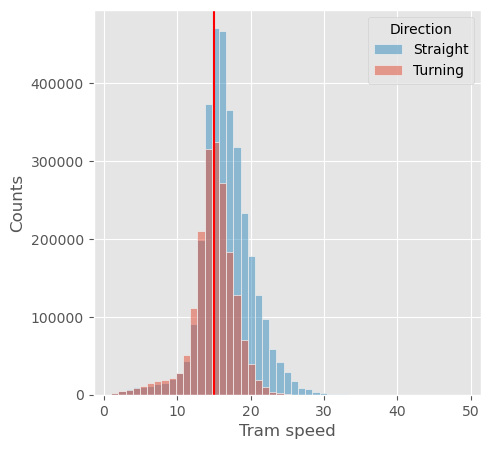

In [20]:
plt.figure(figsize=(5, 5))
fig = sb.histplot(
    data=speed_df,
    x='speed',
    hue='is_straight',
    bins=49,
)
plt.legend(title='Direction', loc='upper right', labels=['Straight', 'Turning'])
plt.axvline(15, c='red')

# fig.set_yscale("log")
# plt.title("The distribution of tram speed")
plt.ylabel('Counts')
plt.xlabel('Tram speed')
plt.savefig('./out/distribution.png', dpi=400, bbox_inches='tight')
plt.show()

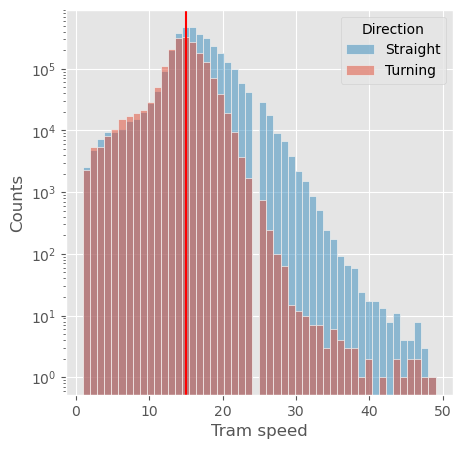

In [12]:
plt.figure(figsize=(5, 5))
fig = sb.histplot(
    data=speed_df,
    x='speed',
    hue='is_straight',
    bins=49,
)
plt.legend(title='Direction', loc='upper right', labels=['Straight', 'Turning'])
plt.axvline(15, c='red')

fig.set_yscale("log")
# plt.title("The distribution of tram speed (log-scale)")
plt.ylabel('Counts')
plt.xlabel('Tram speed')
plt.savefig('./out/distribution_log.png', dpi=400, bbox_inches='tight')
plt.show()

## Spatial analysis

### Tram line

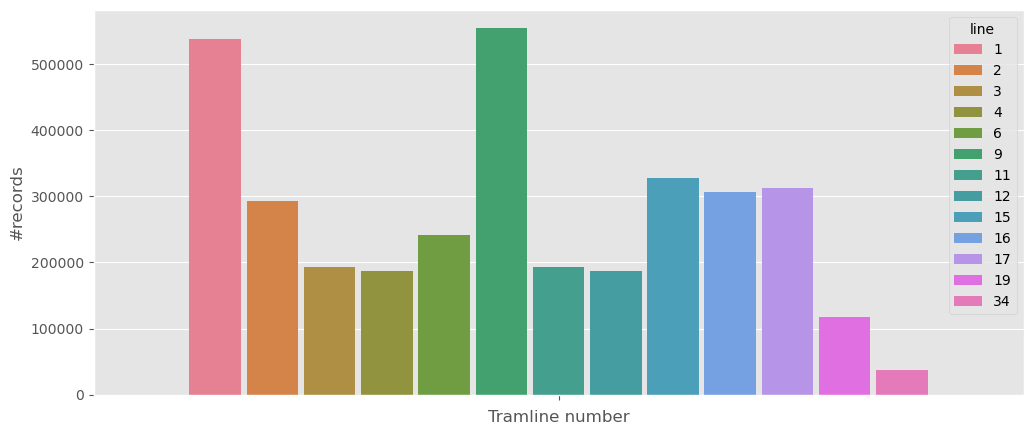

Number of straight over-speeding records in year 2023


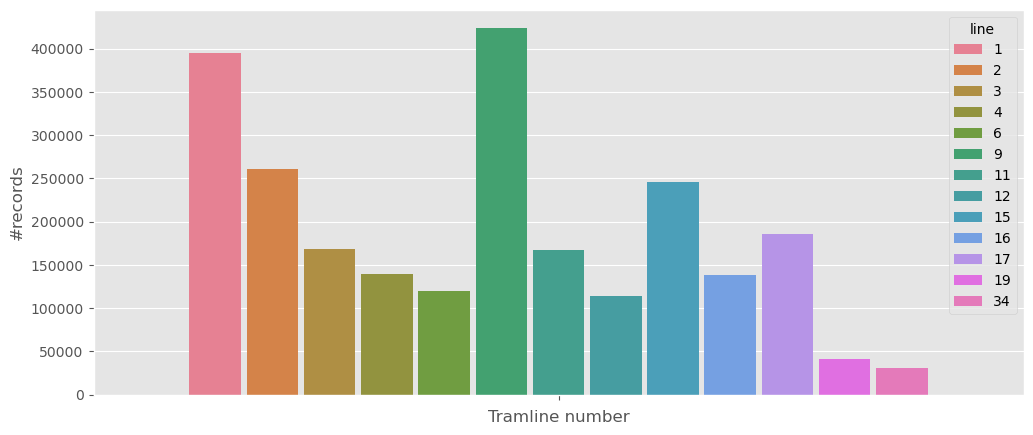

Number of turning over-speeding records in year 2023


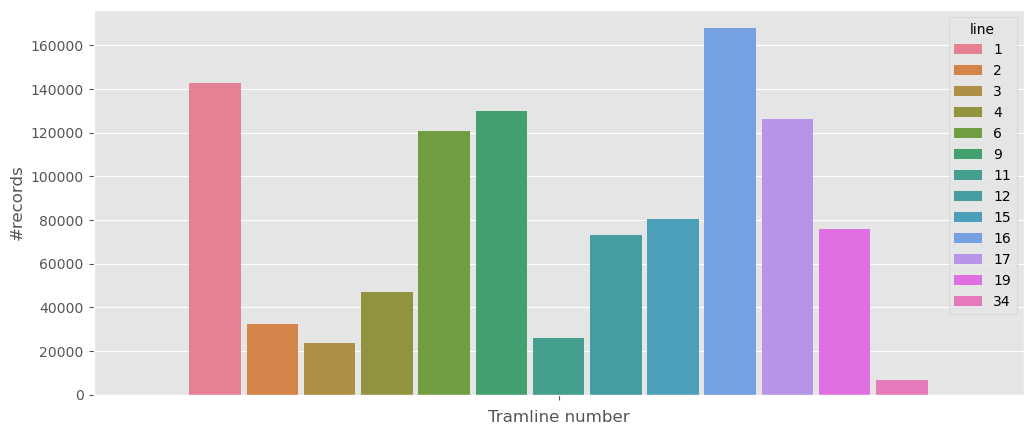

In [10]:
os_tramline = overspeed_df.groupby('line').count()
os_tramline.index = os_tramline.index.astype('int32')

plt.figure(figsize=(12,5))
sb.barplot(data=os_tramline, hue=os_tramline.index, y='vehicle', gap=0.1, legend=True,
            palette=sb.color_palette("husl", 13))

plt.xlabel('Tramline number')
plt.ylabel('#records')
# plt.title(f'Number of over-speeding records in year {year}')
# plt.xticks(rotation=45)
plt.savefig("./out/tramline_combined.png", dpi=500)
plt.show()

straight_os_tramline = overspeed_straight_df.groupby('line').count()
straight_os_tramline.index =  straight_os_tramline.index.astype('int32')

plt.figure(figsize=(12,5))
sb.barplot(data=straight_os_tramline,  hue=os_tramline.index, y='vehicle', gap=0.1, legend=True,
           palette=sb.color_palette("husl", 13)
           )
plt.xlabel('Tramline number')
plt.ylabel('#records')
# plt.title(f'Number of straight over-speeding records in year {year}')
print(f'Number of straight over-speeding records in year 2023')
# plt.xticks(rotation=45)
plt.savefig("./out/tramline_straight.png", dpi=500)
plt.show()

turning_os_tramline = overspeed_turning_df.groupby('line').count()
turning_os_tramline.index =  turning_os_tramline.index.astype('int32')

plt.figure(figsize=(12,5))
sb.barplot(data=turning_os_tramline,  hue=os_tramline.index, y='vehicle', gap=0.1, legend=True,
           palette=sb.color_palette("husl", 13))
plt.xlabel('Tramline number')
plt.ylabel('#records')
# plt.title(f'Number of turning over-speeding records in year {year}')
print(f'Number of turning over-speeding records in year 2023')
# plt.xticks(rotation=45)
plt.savefig("./out/tramline_turning.png", dpi=500)
plt.show()

### Switch

      line switch_number   latitude  longitude
0  91945.0          W059  52.073830   4.322190
1  73660.0          W257  52.076183   4.317654
2  68786.0          W573  52.063975   4.324312
3  66177.0          W018  52.063019   4.311514
4  61871.0          W127  52.068676   4.319281
5  60366.0          W022  52.062152   4.310566
6  59805.0          W262  52.075840   4.318390
7  56883.0          W118  52.067184   4.316612
8  51745.0          W636  52.091412   4.381348
9  51684.0          W583  52.075146   4.305606


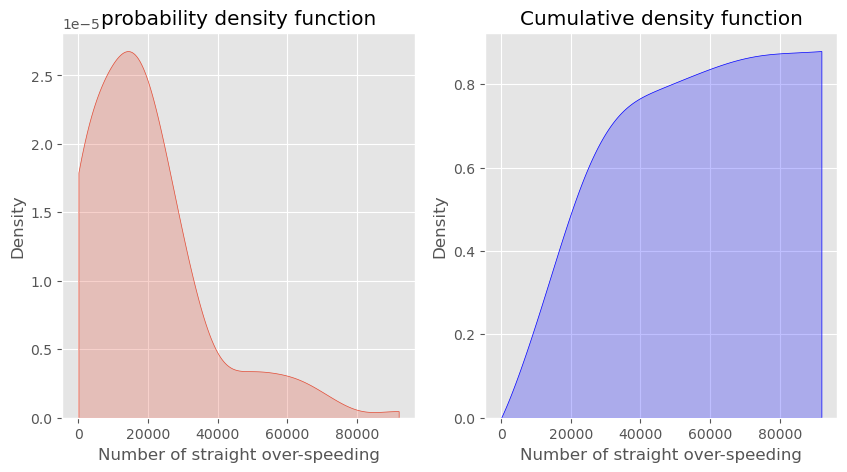

In [11]:
straight_os_switch = overspeed_straight_df.groupby('switch_number').count()
straight_os_switch = straight_os_switch.sort_values(by='line', ascending=False)
straight_os_switch = straight_os_switch[["line", 'year']]
straight_os_switch = pd.concat([straight_os_switch, straight_os_switch.index.to_frame()], axis=1)
straight_os_switch.index.names = ['Number']
straight_os_switch = straight_os_switch.merge(
    gps_wissels_df, 
    left_on='switch_number', 
    right_on='Wissel Nr',
    how='outer',
)

print(straight_os_switch[['line', 'switch_number', 'latitude', 'longitude']].iloc[:10])

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sb.kdeplot(data=straight_os_switch, x='line', cumulative=False, cut=0, fill=True, ax=axs[0])
sb.kdeplot(data=straight_os_switch, x='line', cumulative=True, cut=0, fill=True, ax=axs[1], color='blue')

axs[0].set_xlabel("Number of straight over-speeding")
axs[1].set_xlabel("Number of straight over-speeding")
axs[0].set_title("probability density function")
axs[1].set_title("Cumulative density function")
plt.savefig("./out/cdf_straight_switch.png", dpi=400, bbox_inches='tight')
plt.show()

In [12]:
overspeed_straight_groupby = overspeed_straight_df.groupby(['latitude', 'longitude']).count()
import folium
import selenium
import io
from PIL import Image

# Calculate average latitude and longtitude
average_latitude = overspeed_df['latitude'].mean()
average_longitude = overspeed_df['longitude'].mean()

# background
overspeed_map = folium.Map(location=[average_latitude, average_longitude], zoom_start=13)

# display all the overspeed events' locations.
# for (lat, lon) in overspeed_straight_groupby.index.to_list():
for row_idx in range(10):
    folium.CircleMarker(
        [straight_os_switch.iloc[row_idx]['latitude'], 
         straight_os_switch.iloc[row_idx]['longitude']],
        radius=straight_os_switch.iloc[row_idx]['line'] / 5000,
        color='blue',
        fill=False,
        popup=f"{straight_os_switch.iloc[row_idx]['switch_number']} - {straight_os_switch.iloc[row_idx]['line']}"
    ).add_to(overspeed_map)
overspeed_map

In [13]:
img_data = overspeed_map._to_png(10)
img = Image.open(io.BytesIO(img_data))
img.save('./out/straight_switch_top10.png')

      line switch_number   latitude  longitude
0  60035.0          W117  52.073430   4.322980
1  49790.0          W129  52.068266   4.319169
2  47592.0          W127  52.068676   4.319281
3  38788.0          W079  52.061862   4.309928
4  31437.0          W588  52.082313   4.322641
5  27054.0          W268  52.068570   4.295470
6  25558.0          W537  52.079889   4.324188
7  24539.0          W586  52.080123   4.324011
8  23934.0          W246  52.068640   4.294690
9  23284.0          W184  52.086897   4.371688


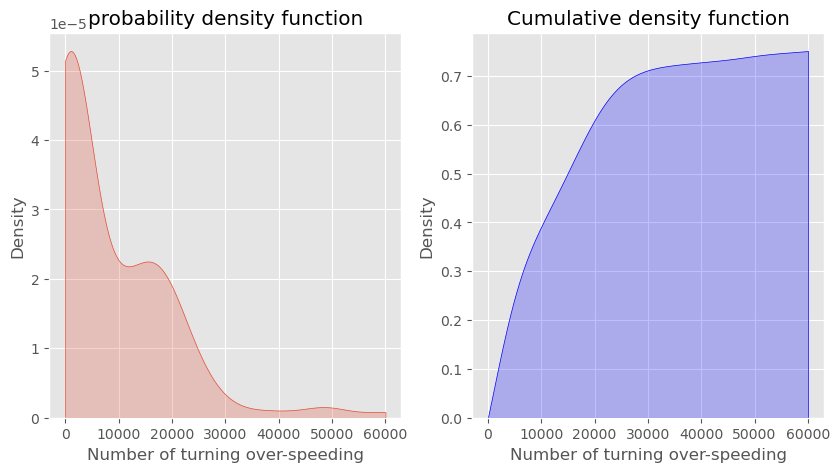

In [14]:
turning_os_switch = overspeed_turning_df.groupby('switch_number').count()
turning_os_switch = turning_os_switch.sort_values(by='line', ascending=False)
turning_os_switch = turning_os_switch[["line", 'year']]
turning_os_switch = pd.concat([turning_os_switch, turning_os_switch.index.to_frame()], axis=1)
turning_os_switch.index.names = ['Number']
turning_os_switch = turning_os_switch.merge(
    gps_wissels_df, 
    left_on='switch_number', 
    right_on='Wissel Nr',
    how='outer',
)

print(turning_os_switch[['line', 'switch_number', 'latitude', 'longitude']].iloc[:10])

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sb.kdeplot(data=turning_os_switch, x='line', cumulative=False, cut=0, fill=True, ax=axs[0])
sb.kdeplot(data=turning_os_switch, x='line', cumulative=True, cut=0, fill=True, ax=axs[1], color='blue')

axs[0].set_xlabel("Number of turning over-speeding")
axs[1].set_xlabel("Number of turning over-speeding")
axs[0].set_title("probability density function")
axs[1].set_title("Cumulative density function")
plt.savefig("./out/cdf_turning_switch.png", dpi=400, bbox_inches='tight')
plt.show()

In [15]:
overspeed_turning_df_groupby = overspeed_turning_df.groupby(['latitude', 'longitude']).count()

# Calculate average latitude and longtitude
average_latitude = overspeed_df['latitude'].mean()
average_longitude = overspeed_df['longitude'].mean()

# background
overspeed_map = folium.Map(location=[average_latitude, average_longitude], zoom_start=13)

# display all the overspeed events' locations.
# for (lat, lon) in overspeed_straight_groupby.index.to_list():
for row_idx in range(10):
    folium.CircleMarker(
        [turning_os_switch.iloc[row_idx]['latitude'], 
         turning_os_switch.iloc[row_idx]['longitude']],
        radius=turning_os_switch.iloc[row_idx]['line'] / 5000,
        color='red',
        fill=False,
        popup=f"{turning_os_switch.iloc[row_idx]['switch_number']} - {turning_os_switch.iloc[row_idx]['line']}"
    ).add_to(overspeed_map)
overspeed_map

In [16]:
img_data = overspeed_map._to_png(60)
img = Image.open(io.BytesIO(img_data))
img.save('./out/turning_switch_top10.png')

C:\Users\Gavin\AppData\Local\Temp\ipykernel_10492\4159545839.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(data=os_switch, x=os_switch.index, y='vehicle',


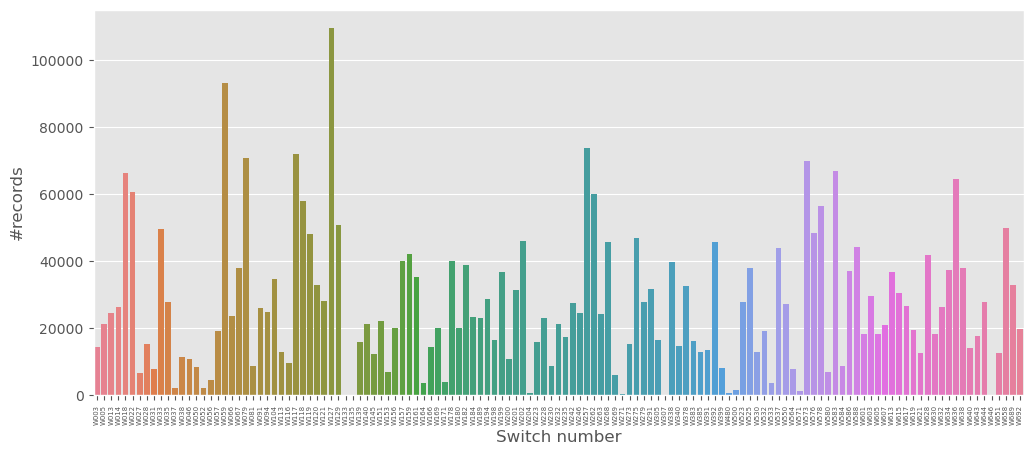

C:\Users\Gavin\AppData\Local\Temp\ipykernel_10492\4159545839.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(data=straight_os_switch, x=straight_os_switch.index, y='vehicle',
C:\Users\Gavin\AppData\Local\Temp\ipykernel_10492\4159545839.py:16: UserWarning: The palette list has more values (131) than needed (128), which may not be intended.
  sb.barplot(data=straight_os_switch, x=straight_os_switch.index, y='vehicle',


Number of straight over-speeding records in year 2023


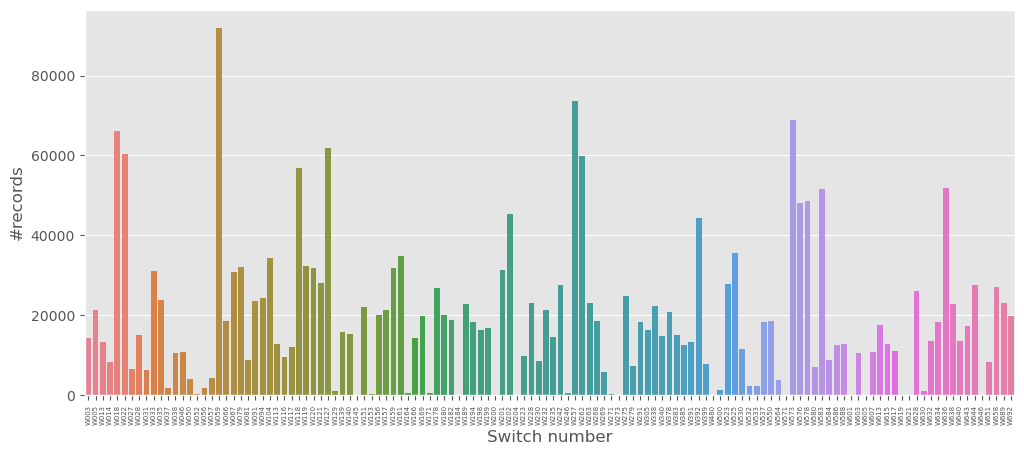

C:\Users\Gavin\AppData\Local\Temp\ipykernel_10492\4159545839.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(data=turning_os_switch, x=turning_os_switch.index, y='vehicle',
C:\Users\Gavin\AppData\Local\Temp\ipykernel_10492\4159545839.py:28: UserWarning: The palette list has more values (131) than needed (124), which may not be intended.
  sb.barplot(data=turning_os_switch, x=turning_os_switch.index, y='vehicle',


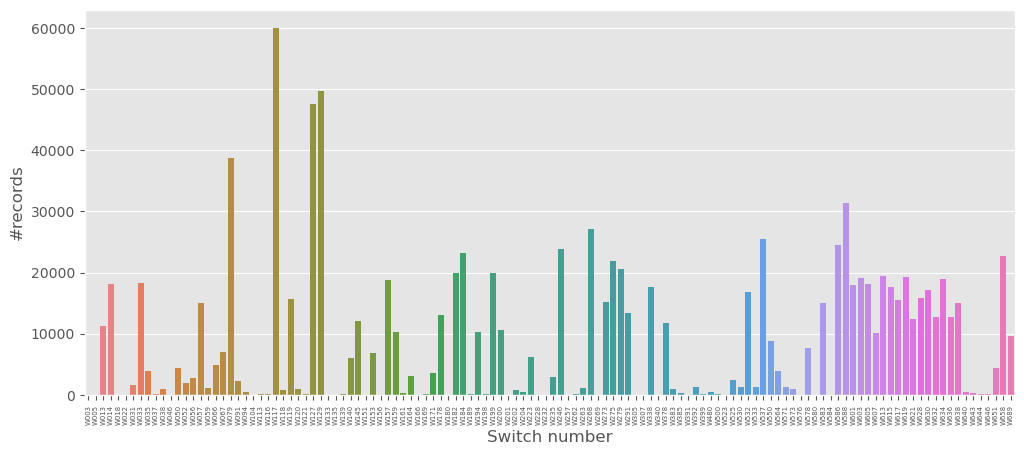

In [17]:
os_switch = overspeed_df.groupby('switch_number').count()

plt.figure(figsize=(12,5))
sb.barplot(data=os_switch, x=os_switch.index, y='vehicle', 
           palette=sb.color_palette("husl", 131))
plt.xlabel('Switch number')
plt.ylabel('#records')
# print(f'Number of over-speeding records in year 2023')
plt.xticks(rotation=90, fontsize=5)
plt.savefig("./out/switch_combined.png", dpi=500)
plt.show()

straight_os_switch = overspeed_straight_df.groupby('switch_number').count()

plt.figure(figsize=(12,5))
sb.barplot(data=straight_os_switch, x=straight_os_switch.index, y='vehicle', 
           palette=sb.color_palette("husl", 131))
plt.xlabel('Switch number')
plt.ylabel('#records')
print(f'Number of straight over-speeding records in year 2023')
plt.xticks(rotation=90, fontsize=5)
plt.savefig("./out/switch_straight.png", dpi=500)
plt.show()

turning_os_switch = overspeed_turning_df.groupby('switch_number').count()

plt.figure(figsize=(12,5))
sb.barplot(data=turning_os_switch, x=turning_os_switch.index, y='vehicle', 
           palette=sb.color_palette("husl", 131))
plt.xlabel('Switch number')
plt.ylabel('#records')
# print(f'Number of turning over-speeding records in year 2023')
plt.xticks(rotation=90, fontsize=5)
plt.savefig("./out/switch_turning.png", dpi=500)
plt.show()

## Temporal analysis

C:\Users\Gavin\AppData\Local\Temp\ipykernel_10492\1342894901.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overspeed_turning_df['#week'] = overspeed_turning_df['hfk_in'].dt.isocalendar()['week']
C:\Users\Gavin\AppData\Local\Temp\ipykernel_10492\1342894901.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overspeed_turning_df['#day'] = overspeed_turning_df['hfk_in'].dt.isocalendar()['day']


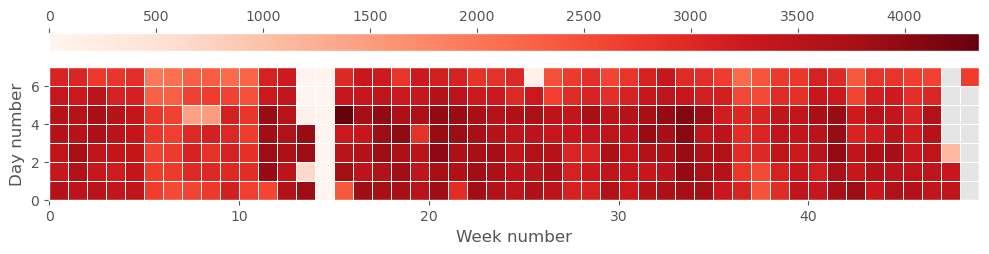

In [18]:
import pylab as pl

overspeed_turning_df = speed_df[
    (speed_df['is_straight'] == False) & (speed_df['speed'] >= 15)
]
overspeed_turning_df['#week'] = overspeed_turning_df['hfk_in'].dt.isocalendar()['week']
overspeed_turning_df['#day'] = overspeed_turning_df['hfk_in'].dt.isocalendar()['day']
overspeed_turning_df = overspeed_turning_df[['#week', '#day', 'line']]
overspeed_turning_df = overspeed_turning_df.groupby(['#week', '#day']).count()
overspeed_turning_df = pd.concat([overspeed_turning_df, overspeed_turning_df.index.to_frame()], axis=1)
overspeed_turning_df.index = [i for i in range(overspeed_turning_df.shape[0])]
overspeed_turning_df.head()
week_day_os_turning_ = overspeed_turning_df.pivot(columns='#week', index='#day', values='line')
Weekday, Week = np.mgrid[:week_day_os_turning_.shape[0]+1, :week_day_os_turning_.shape[1]+1]
fig, ax = pl.subplots(figsize=(12, 4))
ax.set_aspect("equal")
pl.pcolormesh(Week, Weekday, week_day_os_turning_.values, cmap="Reds", edgecolor="w", vmin=0, vmax=overspeed_turning_df['line'].max())
cbar = pl.colorbar(orientation='horizontal', aspect=50, location='top')
pl.xlim(0, week_day_os_turning_.shape[1])
pl.ylabel("Day number")
pl.xlabel("Week number")
pl.savefig("temporal_turning_overspeed.png", dpi=400, bbox_inches='tight')

C:\Users\Gavin\AppData\Local\Temp\ipykernel_10492\3702841992.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overspeed_straight_df['#week'] = overspeed_straight_df['hfk_in'].dt.isocalendar()['week']
C:\Users\Gavin\AppData\Local\Temp\ipykernel_10492\3702841992.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overspeed_straight_df['#day'] = overspeed_straight_df['hfk_in'].dt.isocalendar()['day']


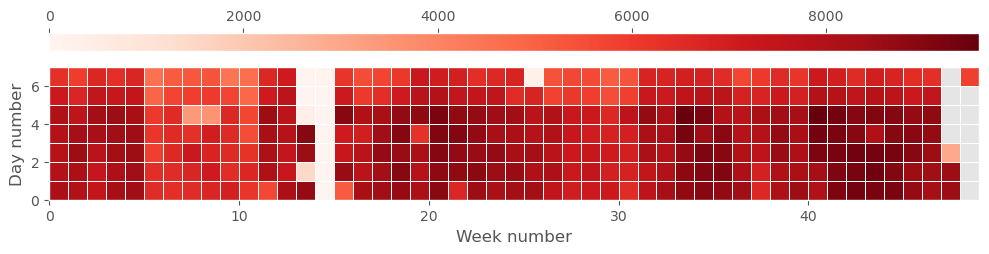

In [19]:
overspeed_straight_df = speed_df[
    (speed_df['is_straight'] == True) & (speed_df['speed'] >= 15)
]
overspeed_straight_df['#week'] = overspeed_straight_df['hfk_in'].dt.isocalendar()['week']
overspeed_straight_df['#day'] = overspeed_straight_df['hfk_in'].dt.isocalendar()['day']
overspeed_straight_df = overspeed_straight_df[['#week', '#day', 'line']]
overspeed_straight_df = overspeed_straight_df.groupby(['#week', '#day']).count()
overspeed_straight_df = pd.concat([overspeed_straight_df, overspeed_straight_df.index.to_frame()], axis=1)
overspeed_straight_df.index = [i for i in range(overspeed_straight_df.shape[0])]
overspeed_straight_df.head()
week_day_os_turning_ = overspeed_straight_df.pivot(columns='#week', index='#day', values='line')
Weekday, Week = np.mgrid[:week_day_os_turning_.shape[0]+1, :week_day_os_turning_.shape[1]+1]
fig, ax = pl.subplots(figsize=(12, 4))
ax.set_aspect("equal")
pl.pcolormesh(Week, Weekday, week_day_os_turning_.values, cmap="Reds", edgecolor="w", vmin=0, vmax=overspeed_straight_df['line'].max())
cbar = pl.colorbar(orientation='horizontal', aspect=50, location='top')
pl.xlim(0, week_day_os_turning_.shape[1])
pl.ylabel("Day number")
pl.xlabel("Week number")
pl.savefig("temporal_straight_overspeed.png", dpi=400, bbox_inches='tight')

C:\Users\Gavin\AppData\Local\Temp\ipykernel_10492\3087321142.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overspeed_turning_df['#week'] = overspeed_turning_df['hfk_in'].dt.isocalendar()['week']
C:\Users\Gavin\AppData\Local\Temp\ipykernel_10492\3087321142.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overspeed_turning_df['#day'] = overspeed_turning_df['hfk_in'].dt.isocalendar()['day']
C:\Users\Gavin\AppData\Local\Temp\ipykernel_10492\3087321142.py:26: SettingWithCopyWarning: 
A value is trying t

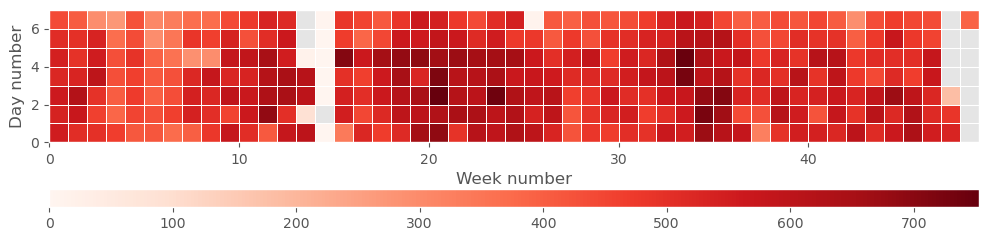

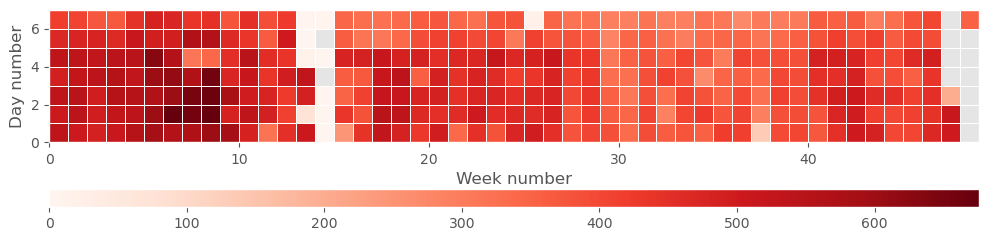

In [20]:
overspeed_turning_df = speed_df[
    (speed_df['is_straight'] == False) & (speed_df['speed'] >= 15) & (speed_df['line'] == 16)
]
overspeed_turning_df['#week'] = overspeed_turning_df['hfk_in'].dt.isocalendar()['week']
overspeed_turning_df['#day'] = overspeed_turning_df['hfk_in'].dt.isocalendar()['day']
overspeed_turning_df = overspeed_turning_df[['#week', '#day', 'vehicle']]
overspeed_turning_df = overspeed_turning_df.groupby(['#week', '#day']).count()
overspeed_turning_df = pd.concat([overspeed_turning_df, overspeed_turning_df.index.to_frame()], axis=1)
overspeed_turning_df.index = [i for i in range(overspeed_turning_df.shape[0])]
overspeed_turning_df.head()
week_day_os_turning_ = overspeed_turning_df.pivot(columns='#week', index='#day', values='vehicle')
Weekday, Week = np.mgrid[:week_day_os_turning_.shape[0]+1, :week_day_os_turning_.shape[1]+1]
fig, ax = pl.subplots(figsize=(12, 4))
ax.set_aspect("equal")
max_tramline = overspeed_turning_df['vehicle'].max()
pl.pcolormesh(Week, Weekday, week_day_os_turning_.values, cmap="Reds", edgecolor="w", vmin=0, vmax=max_tramline)
cbar = pl.colorbar(orientation='horizontal', aspect=50, location='bottom')
pl.xlim(0, week_day_os_turning_.shape[1])
pl.ylabel("Day number")
pl.xlabel("Week number")
pl.savefig("./out/temporal_turning_overspeed_line16.png", dpi=400, bbox_inches='tight')

overspeed_turning_df = speed_df[
    (speed_df['is_straight'] == True) & (speed_df['speed'] >= 15) & (speed_df['line'] == 16)
]
overspeed_turning_df['#week'] = overspeed_turning_df['hfk_in'].dt.isocalendar()['week']
overspeed_turning_df['#day'] = overspeed_turning_df['hfk_in'].dt.isocalendar()['day']
overspeed_turning_df = overspeed_turning_df[['#week', '#day', 'vehicle']]
overspeed_turning_df = overspeed_turning_df.groupby(['#week', '#day']).count()
overspeed_turning_df = pd.concat([overspeed_turning_df, overspeed_turning_df.index.to_frame()], axis=1)
overspeed_turning_df.index = [i for i in range(overspeed_turning_df.shape[0])]
overspeed_turning_df.head()
week_day_os_turning_ = overspeed_turning_df.pivot(columns='#week', index='#day', values='vehicle')
Weekday, Week = np.mgrid[:week_day_os_turning_.shape[0]+1, :week_day_os_turning_.shape[1]+1]
fig, ax = pl.subplots(figsize=(12, 4))
ax.set_aspect("equal")
max_tramline = overspeed_turning_df['vehicle'].max()
pl.pcolormesh(Week, Weekday, week_day_os_turning_.values, cmap="Reds", edgecolor="w", vmin=0, vmax=max_tramline)
cbar = pl.colorbar(orientation='horizontal', aspect=50, location='bottom')
pl.xlim(0, week_day_os_turning_.shape[1])
pl.ylabel("Day number")
pl.xlabel("Week number")
pl.savefig("./out/temporal_straight_overspeed_line16.png", dpi=400, bbox_inches='tight')

C:\Users\Gavin\AppData\Local\Temp\ipykernel_10492\207071356.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overspeed_turning_df['#week'] = overspeed_turning_df['hfk_in'].dt.isocalendar()['week']
C:\Users\Gavin\AppData\Local\Temp\ipykernel_10492\207071356.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overspeed_turning_df['#day'] = overspeed_turning_df['hfk_in'].dt.isocalendar()['day']
C:\Users\Gavin\AppData\Local\Temp\ipykernel_10492\207071356.py:26: SettingWithCopyWarning: 
A value is trying to b

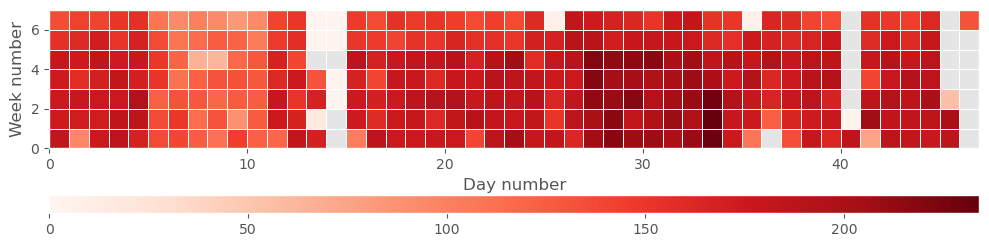

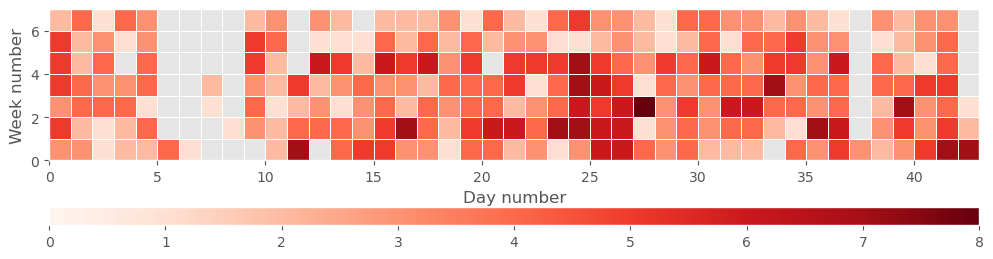

In [21]:
overspeed_turning_df = speed_df[
    (speed_df['is_straight'] == False) & (speed_df['speed'] >= 15) & (speed_df['switch_number'] == 'W129')
]
overspeed_turning_df['#week'] = overspeed_turning_df['hfk_in'].dt.isocalendar()['week']
overspeed_turning_df['#day'] = overspeed_turning_df['hfk_in'].dt.isocalendar()['day']
overspeed_turning_df = overspeed_turning_df[['#week', '#day', 'vehicle']]
overspeed_turning_df = overspeed_turning_df.groupby(['#week', '#day']).count()
overspeed_turning_df = pd.concat([overspeed_turning_df, overspeed_turning_df.index.to_frame()], axis=1)
overspeed_turning_df.index = [i for i in range(overspeed_turning_df.shape[0])]
overspeed_turning_df.head()
week_day_os_turning_ = overspeed_turning_df.pivot(columns='#week', index='#day', values='vehicle')
Weekday, Week = np.mgrid[:week_day_os_turning_.shape[0]+1, :week_day_os_turning_.shape[1]+1]
fig, ax = pl.subplots(figsize=(12, 4))
ax.set_aspect("equal")
pl.pcolormesh(Week, Weekday, week_day_os_turning_.values, cmap="Reds", edgecolor="w", 
              vmin=0, vmax=overspeed_turning_df['vehicle'].max())
cbar = pl.colorbar(orientation='horizontal', aspect=50, location='bottom')
pl.xlim(0, week_day_os_turning_.shape[1])
pl.xlabel("Day number")
pl.ylabel("Week number")
pl.savefig("./out/temporal_turning_overspeed_switch129.png", dpi=400, bbox_inches='tight')

overspeed_turning_df = speed_df[
    (speed_df['is_straight'] == True) & (speed_df['speed'] >= 15) & (speed_df['switch_number'] == 'W129')
]
overspeed_turning_df['#week'] = overspeed_turning_df['hfk_in'].dt.isocalendar()['week']
overspeed_turning_df['#day'] = overspeed_turning_df['hfk_in'].dt.isocalendar()['day']
overspeed_turning_df = overspeed_turning_df[['#week', '#day', 'vehicle']]
overspeed_turning_df = overspeed_turning_df.groupby(['#week', '#day']).count()
overspeed_turning_df = pd.concat([overspeed_turning_df, overspeed_turning_df.index.to_frame()], axis=1)
overspeed_turning_df.index = [i for i in range(overspeed_turning_df.shape[0])]
overspeed_turning_df.head()
week_day_os_turning_ = overspeed_turning_df.pivot(columns='#week', index='#day', values='vehicle')
Weekday, Week = np.mgrid[:week_day_os_turning_.shape[0]+1, :week_day_os_turning_.shape[1]+1]
fig, ax = pl.subplots(figsize=(12, 4))
ax.set_aspect("equal")
pl.pcolormesh(Week, Weekday, week_day_os_turning_.values, cmap="Reds", edgecolor="w", 
              vmin=0, vmax=overspeed_turning_df['vehicle'].max())
cbar = pl.colorbar(orientation='horizontal', aspect=50, location='bottom')
pl.xlim(0, week_day_os_turning_.shape[1])
pl.xlabel("Day number")
pl.ylabel("Week number")
pl.savefig("./out/temporal_straight_overspeed_switch129.png", dpi=400, bbox_inches='tight')